In [1]:
import Pkg
Pkg.add("TikzPictures"); using TikzPictures
Pkg.add("Combinatorics"); using Combinatorics

    Updating registry at `C:\Users\Artyom\.julia\registries\General.toml`
   Resolving package versions...
  No Changes to `C:\Users\Artyom\.julia\environments\v1.8\Project.toml`
  No Changes to `C:\Users\Artyom\.julia\environments\v1.8\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\Artyom\.julia\environments\v1.8\Project.toml`
  No Changes to `C:\Users\Artyom\.julia\environments\v1.8\Manifest.toml`


In [18]:
function paths_from_sources(source_list::Array{Char})
    L = length(source_list)
    path_list = Array{Tuple{Char,Char}}(undef,(L*(L-1))÷2)
    ind = 1
    for i=1:L
        for j=i+1:L
            path_list[ind] = (source_list[i],source_list[j])
            ind += 1
        end
    end
    return path_list
end

paths_from_sources (generic function with 1 method)

In [19]:
function edges_recursive(selected::Vector{Int8},path_list::Vector{Tuple{Char,Char}},source_list::Array{Char},in_chars::Set{Char},out_chars::Set{Char})
    if length(selected) == length(path_list)
        if all(selected .== 0)
            return []
        end
        return [selected]
    end

    possible_edges = Vector{Vector{Int8}}(undef,0)
    next_path = path_list[length(selected)+1]

    if !(next_path[1] in out_chars) && !(next_path[2] in in_chars)
        new_selected = vcat(selected,Vector{Int8}([1]))
        new_in = union(in_chars,[next_path[1]])
        new_out = union(out_chars,[next_path[2]])
        edges = edges_recursive(new_selected,path_list,source_list,new_in,new_out)
        append!(possible_edges,edges)
    end

    if !(next_path[1] in in_chars) && !(next_path[2] in out_chars)
        new_selected = vcat(selected,Vector{Int8}([-1]))
        new_in = union(in_chars,[next_path[2]])
        new_out = union(out_chars,[next_path[1]])
        edges = edges_recursive(new_selected,path_list,source_list,new_in,new_out)
        append!(possible_edges,edges)
    end

    new_selected = vcat(selected,Vector{Int8}([0]))
    edges = edges_recursive(new_selected,path_list,source_list,in_chars,out_chars)
    append!(possible_edges,edges)

    return possible_edges
end

function edges_from_paths(path_list::Array{Tuple{Char,Char}},source_list::Array{Char})
    return edges_recursive(Vector{Int8}([]),path_list,source_list,Set{Char}(),Set{Char}())
end

edges_from_paths (generic function with 1 method)

In [20]:
function vertices_from_edges(edge_list::Vector{Vector{Int8}},path_list::Array{Tuple{Char,Char}},source_list::Array{Char})
    vertex_list = Vector{Array{Vector{Int8}}}([])
    for i=1:length(edge_list)
        edge = edge_list[i]
        if sum(abs.(edge)) == 1
            continue
        end
        out_chars = Vector{Char}([])
        out_char_corresponding_inds = []
        for j=1:length(edge)
            if edge[j]==0
                continue
            end

            if edge[j]==1
                index = findfirst(out_chars .== path_list[j][2])
                if index==nothing
                    push!(out_chars,path_list[j][2])
                    push!(out_char_corresponding_inds,[j])
                    continue
                end
                push!(out_char_corresponding_inds[index],j)
            end

            if edge[j]==-1
                index = findfirst(out_chars .== path_list[j][1])
                if index==nothing
                    push!(out_chars,path_list[j][1])
                    push!(out_char_corresponding_inds,[j])
                    continue
                end
                push!(out_char_corresponding_inds[index],j)
            end
        end

        if length(out_chars) == 1
            continue
        end

        for c in combinations(2:length(out_chars))
            left_char_inds = append!([1],setdiff(2:length(out_chars),c))
            right_char_inds = c

            left_path_inds = vcat([out_char_corresponding_inds[j] for j in left_char_inds]...)
            right_path_inds = vcat([out_char_corresponding_inds[j] for j in right_char_inds]...)

            vertex = Array{Vector{Int8}}(undef,3)
            vertex[1] = edge
            vertex[2] = [j in left_path_inds ? -edge[j] : 0 for j=1:length(edge)]
            vertex[3] = [j in right_path_inds ? -edge[j] : 0 for j=1:length(edge)]
            push!(vertex_list,vertex)
        end
    end

    return vertex_list
end

vertices_from_edges (generic function with 1 method)

In [21]:
function splitting_compatibility_and_requirement(vertex_list,path_list)
    L = length(vertex_list)
    compatibility = Array{Bool}(undef,(L,L))
    requirement = Array{Bool}(undef,(L,L))
    path_count = length(path_list)
    for i=1:length(vertex_list)
        compatibility[i,i] = false
        requirement[i,i] = false
        for j=(i+1):length(vertex_list)
            v1 = vertex_list[i]
            v2 = vertex_list[j]

            compatibility_flag = true
            requirement_flag = false

            for p1=1:path_count
                for p2=1:path_count
                    if v1[2][p1]!=0 && v1[3][p2]!=0
                        if v2[2][p1]!=0 && v2[3][p2]!=0
                            if (v1[2][p1],v1[3][p2]) == (v2[2][p1],v2[3][p2]) ||
                                (v1[2][p1]*v1[3][p2]) != (v2[2][p1]*v2[3][p2])
                                compatibility_flag = false
                            else
                                requirement_flag = true
                            end
                        elseif v2[3][p1]!=0 && v2[2][p2]!=0
                            if (v1[2][p1],v1[3][p2]) == (v2[3][p1],v2[2][p2]) ||
                                (v1[2][p1]*v1[3][p2]) != (v2[3][p1]*v2[2][p2])
                                compatibility_flag = false
                            else
                                requirement_flag = true
                            end
                        end
                    end
                end
            end

            if compatibility_flag
                """v1_inputs = Set([v1[1][i]==1 ? (path_list[i][1]) : (path_list[i][2]) for i=1:path_count if v1[1][i]!=0])
                v1_outputs = Set([v1[1][i]==1 ? (path_list[i][2]) : (path_list[i][1]) for i=1:path_count if v1[1][i]!=0])

                v2_inputs = Set([v2[1][i]==1 ? (path_list[i][1]) : (path_list[i][2]) for i=1:path_count if v2[1][i]!=0])
                v2_outputs = Set([v2[1][i]==1 ? (path_list[i][2]) : (path_list[i][1]) for i=1:path_count if v2[1][i]!=0])

                if (v1_inputs==v2_inputs && v1_outputs==v2_outputs) ||
                    (v1_inputs==v2_outputs && v1_outputs==v2_inputs)
                    v1_paths = Set(findall(v1[1].!=0))
                    v2_paths = Set(findall(v2[1].!=0))
                    if !issubset(v1_paths,v2_paths) && !issubset(v2_paths,v1_paths)
                        compatibility_flag = false
                    end
                end"""

                v1_connections = [path_list[i][j] for i=1:path_count if v1[1][i]!=0 for j=1:2]
                v2_connections = [path_list[i][j] for i=1:path_count if v2[1][i]!=0 for j=1:2]

                if sort(v1_connections) == sort(v2_connections)
                    v1_paths = Set(findall(v1[1].!=0))
                    v2_paths = Set(findall(v2[1].!=0))
                    if !issubset(v1_paths,v2_paths) && !issubset(v2_paths,v1_paths)
                        compatibility_flag = false
                    end
                end
            end

            compatibility[i,j] = compatibility_flag
            compatibility[j,i] = compatibility_flag
            requirement[i,j] = requirement_flag
            requirement[j,i] = requirement_flag
        end
    end

    return compatibility,requirement
end

function connecting_edge_requirement_dictionary(vertex_list)
    dict = Dict{Vector{Int8},Vector{Int}}()

    for i=1:length(vertex_list)
        v = vertex_list[i]

        for j=1:3
            e = v[j]
            has_key = get(dict,e,false)!=false
            if has_key
                push!(dict[e],i)
            else
                dict[e] = [i]
            end
        end
    end

    return dict
end

function recursive_set_calculation(loose_edges,selected,remaining,compatibility,requirement,edge_dictionary,vertex_list)
    available = selected .|| remaining
    for i in findall(selected)
        r = requirement[i,:]
        if any(r) && !any(r .&& available)
            return []
        end
    end
    
    for e in loose_edges
        possible_vertices = get(edge_dictionary,-e,[])
        if !any(remaining[possible_vertices])
            return []
        end
    end

    ind = findfirst(remaining)

    if ind==nothing
        return [selected]
    end

    included_selected = copy(selected)
    included_selected[ind] = true
    included_remaining = remaining .&& compatibility[ind,:]
    included_remaining[ind] = false

    included_loose_edges = copy(loose_edges)
    for e in vertex_list[ind]
        if (-e) in included_loose_edges
            match = [edge==(-e) for edge in included_loose_edges]
            corresponding_index = findfirst(match)
            popat!(included_loose_edges,corresponding_index)
        else
            push!(included_loose_edges,e)
        end
    end

    included_sets = recursive_set_calculation(  included_loose_edges,
                                                included_selected,
                                                included_remaining,
                                                compatibility,
                                                requirement,
                                                edge_dictionary,
                                                vertex_list)

    excluded_selected = selected
    excluded_loose_edge = loose_edges
    excluded_remaining = copy(remaining)
    excluded_remaining[ind] = false
    
    excluded_sets = recursive_set_calculation(  excluded_loose_edge,
                                                excluded_selected,
                                                excluded_remaining,
                                                compatibility,
                                                requirement,
                                                edge_dictionary,
                                                vertex_list)

    return vcat(included_sets,excluded_sets)
end

function starting_edges_from_paths(path_list,source_list)
    edges = Vector{Vector{Int8}}(undef,length(source_list))
    for i=1:length(source_list)
        edges[i] = zeros(Int8,length(path_list))
        for j=1:length(path_list)
            if path_list[j][1]==source_list[i]
                edges[i][j] = -1
            elseif path_list[j][2]==source_list[i]
                edges[i][j] = 1
            end
        end
    end

    return edges
end

starting_edges_from_paths (generic function with 1 method)

In [22]:
function connect_vertices(vertices,starting_edges)
    dict = Dict{Vector{Int8},Tuple{Vector{Tuple{Int,Int}},Vector{Tuple{Int,Int}}}}()

    for i=1:length(starting_edges)
        e = starting_edges[i]
        dict[e] = ([(-i,i)],[])
    end

    for i=1:length(vertices)
        v = vertices[i]

        for j=1:3
            e = v[j]
            direct_entry = get(dict,e,false)
            conjugate_entry = get(dict,-e,false)
            if (direct_entry != false)
                push!( dict[e][1] , (i,j) )
            elseif (conjugate_entry != false)
                push!( dict[-e][2] , (i,j) )
            else
                dict[e] = ([(i,j)],[])
            end
        end
    end

    dict_keys = collect(keys(dict))
    conjugate_indices = [dict[k][2] for k in dict_keys]
    conjugate_options = [collect(permutations(c)) for c in conjugate_indices]

    if prod(length.(conjugate_indices)) == 1
        out_connections = Array{Array{Int}}(undef,1)
        out_connections[1] = Array{Int}(undef,(length(vertices),3))
        for k=1:length(dict_keys)
            left = dict[dict_keys[k]][1][1]
            right = dict[dict_keys[k]][2][1]
            if left[1] > 0
                out_connections[1][left[1],left[2]] = right[1]
            end
            if right[1] > 0
                out_connections[1][right[1],right[2]] = left[1]
            end
        end
        return out_connections
    end

    connection_possibilities = reduce(vcat,Iterators.product(conjugate_options...) |> collect)

    out_connections = Array{Array{Int}}(undef,length(connection_possibilities))
    for i=1:length(connection_possibilities)
        c = connection_possibilities[i]
        out_connections[i] = Array{Int}(undef,(length(vertices),3))
        for k=1:length(dict_keys)
            for j=1:length(dict[dict_keys[k]][1])
                left = dict[dict_keys[k]][1][j]
                right = c[k][j]
                if left[1] > 0
                    out_connections[i][left[1],left[2]] = right[1]
                end
                if right[1] > 0
                    out_connections[i][right[1],right[2]] = left[1]
                end
            end
        end
    end

    return out_connections
end

function validate_connection(vertices,connection,path_count)
    for p=1:path_count
        relevant_vertices = Set{Int}([])
        for v=1:length(vertices)
            if vertices[v][1][p] != 0
                push!(relevant_vertices,v)
            end
        end
        v = pop!(relevant_vertices)
        queue = [v]
        used = []
        while length(queue) != 0
            cur = pop!(queue)
            push!(used,cur)

            for i=1:3
                edge = vertices[cur][i]
                if edge[p] != 0
                    connected = connection[cur,i]
                    if connected in relevant_vertices
                        push!(queue,connected)
                        delete!(relevant_vertices,connected)
                    elseif (connected > 0) && !(connected in used)
                        return false
                    end
                end
            end
        end
        if length(relevant_vertices) > 0
            return false
        end
    end

    return true
end

function generate_valid_graphs(vertex_sets,vertex_list,starting_edges,path_count)
    graphs = Vector{Tuple{Vector{Array{Vector{Int8}}},Array{Int64}}}(undef,0)
    for s in vertex_sets
        vertices = vertex_list[s]
        connections = connect_vertices(vertices,starting_edges)
        for c in connections
            if validate_connection(vertices,c,path_count)
                push!(graphs,(vertices,c))
            end
        end
    end
    return graphs
end

generate_valid_graphs (generic function with 1 method)

In [23]:
source_list = ['A','B','C','D']
path_list = paths_from_sources(source_list)
edge_list = edges_from_paths(path_list,source_list)
vertex_list = vertices_from_edges(edge_list,path_list,source_list)

66-element Vector{Array{Vector{Int8}}}:
 [[1, 1, 1, 0, 0, 0], [-1, 0, -1, 0, 0, 0], [0, -1, 0, 0, 0, 0]]
 [[1, 1, 1, 0, 0, 0], [-1, -1, 0, 0, 0, 0], [0, 0, -1, 0, 0, 0]]
 [[1, 1, 1, 0, 0, 0], [-1, 0, 0, 0, 0, 0], [0, -1, -1, 0, 0, 0]]
 [[1, 1, 0, 0, -1, -1], [-1, 0, 0, 0, 1, 0], [0, -1, 0, 0, 0, 1]]
 [[1, 1, 0, 0, -1, 0], [-1, 0, 0, 0, 1, 0], [0, -1, 0, 0, 0, 0]]
 [[1, 1, 0, 0, 0, -1], [-1, 0, 0, 0, 0, 0], [0, -1, 0, 0, 0, 1]]
 [[1, 1, 0, 0, 0, 0], [-1, 0, 0, 0, 0, 0], [0, -1, 0, 0, 0, 0]]
 [[1, 0, 1, -1, 0, 1], [-1, 0, 0, 1, 0, 0], [0, 0, -1, 0, 0, -1]]
 [[1, 0, 1, -1, 0, 0], [-1, 0, 0, 1, 0, 0], [0, 0, -1, 0, 0, 0]]
 [[1, 0, 1, 0, 0, 1], [-1, 0, 0, 0, 0, 0], [0, 0, -1, 0, 0, -1]]
 [[1, 0, 1, 0, 0, 0], [-1, 0, 0, 0, 0, 0], [0, 0, -1, 0, 0, 0]]
 [[1, 0, 0, -1, 0, 1], [-1, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, -1]]
 [[1, 0, 0, 0, -1, -1], [-1, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 1]]
 ⋮
 [[0, 0, -1, 1, 0, -1], [0, 0, 1, 0, 0, 0], [0, 0, 0, -1, 0, 1]]
 [[0, 0, -1, 1, 0, 0], [0, 0, 1, 0, 0, 0], [0, 

In [24]:
c,r = splitting_compatibility_and_requirement(vertex_list,path_list)

(Bool[0 0 … 1 1; 0 0 … 1 1; … ; 1 1 … 0 1; 1 1 … 1 0], Bool[0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0])

In [25]:
e = connecting_edge_requirement_dictionary(vertex_list)

Dict{Vector{Int8}, Vector{Int64}} with 82 entries:
  [0, 0, -1, 1, 0, 0]    => [56]
  [1, 1, 0, 0, 0, 0]     => [7, 16, 17, 18]
  [0, 0, -1, 1, 0, -1]   => [55]
  [-1, 0, -1, 0, 0, 0]   => [1]
  [1, 1, 0, 0, 0, -1]    => [6]
  [0, -1, 0, 0, 1, 1]    => [47]
  [-1, 0, -1, 0, 0, -1]  => [21]
  [0, -1, -1, 0, -1, 0]  => [41]
  [0, 1, 0, 1, 0, 0]     => [44]
  [0, -1, -1, 0, 0, 0]   => [3]
  [0, 0, 1, -1, 0, 1]    => [53]
  [1, 0, 1, 0, 0, 1]     => [10]
  [0, 1, 0, 0, 1, 0]     => [36]
  [0, 0, 1, 1, 1, 0]     => [51]
  [0, -1, -1, -1, -1, 0] => [39]
  [0, 0, 0, 0, -1, 0]    => [17, 23, 28, 35, 36, 48, 64]
  [-1, 0, -1, 1, 0, 0]   => [20]
  [0, 0, 0, 0, -1, -1]   => [16, 27, 47, 66]
  [-1, 0, -1, 1, 0, -1]  => [19]
  [-1, -1, 0, 0, 1, 1]   => [16]
  [0, -1, -1, -1, 0, 0]  => [40]
  [1, 0, 1, -1, 0, 1]    => [8]
  [0, 0, 0, 0, 0, -1]    => [12, 14, 18, 29, 44, 50, 65]
  [0, 1, 0, 1, 1, 0]     => [35]
  [0, 1, 1, 0, 0, 0]     => [34, 39, 40, 41]
  ⋮                      => ⋮

In [26]:
starting_edges = starting_edges_from_paths(path_list,source_list)

4-element Vector{Vector{Int8}}:
 [-1, -1, -1, 0, 0, 0]
 [1, 0, 0, -1, -1, 0]
 [0, 1, 0, 1, 0, -1]
 [0, 0, 1, 0, 1, 1]

In [27]:
vertex_sets = recursive_set_calculation(starting_edges,zeros(Bool,length(vertex_list)),ones(Bool,length(vertex_list)),c,r,e,vertex_list)

1134-element Vector{Any}:
 Bool[1, 0, 0, 0, 0, 0, 0, 1, 0, 0  …  0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
 Bool[1, 0, 0, 0, 0, 0, 0, 1, 0, 0  …  0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
 Bool[1, 0, 0, 0, 0, 0, 0, 1, 0, 0  …  0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
 Bool[1, 0, 0, 0, 0, 0, 0, 0, 1, 0  …  0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
 Bool[1, 0, 0, 0, 0, 0, 0, 0, 1, 0  …  0, 0, 1, 0, 0, 0, 1, 0, 0, 0]
 Bool[1, 0, 0, 0, 0, 0, 0, 0, 1, 0  …  0, 0, 0, 1, 0, 1, 0, 0, 0, 0]
 Bool[1, 0, 0, 0, 0, 0, 0, 0, 1, 0  …  0, 0, 0, 0, 1, 0, 0, 0, 0, 1]
 Bool[1, 0, 0, 0, 0, 0, 0, 0, 1, 0  …  0, 0, 1, 0, 0, 0, 1, 0, 0, 0]
 Bool[1, 0, 0, 0, 0, 0, 0, 0, 1, 0  …  0, 0, 0, 1, 0, 1, 0, 0, 0, 0]
 Bool[1, 0, 0, 0, 0, 0, 0, 0, 1, 0  …  0, 0, 0, 0, 1, 0, 0, 0, 0, 1]
 Bool[1, 0, 0, 0, 0, 0, 0, 0, 1, 0  …  0, 0, 1, 0, 0, 0, 1, 0, 1, 0]
 Bool[1, 0, 0, 0, 0, 0, 0, 0, 1, 0  …  0, 0, 0, 1, 0, 1, 0, 0, 1, 0]
 Bool[1, 0, 0, 0, 0, 0, 0, 0, 1, 0  …  0, 0, 0, 0, 1, 0, 0, 0, 1, 1]
 ⋮
 Bool[0, 0, 1, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 1, 0, 0, 1, 0, 1]
 Bool

In [28]:
vertex_list[1]

3-element Vector{Vector{Int8}}:
 [1, 1, 1, 0, 0, 0]
 [-1, 0, -1, 0, 0, 0]
 [0, -1, 0, 0, 0, 0]

In [29]:
graph_list = generate_valid_graphs(vertex_sets,vertex_list,starting_edges,length(path_list))
length(graph_list)

906

In [44]:
A_split = 'B'
B_split = 'A'
C_split = 'D'
D_split = 'C'

if A_split == 'B'
    v1 = [ [1,1,1,0,0,0] , [-1,0,0,0,0,0] , [0,-1,-1,0,0,0] ]
elseif A_split == 'C'
    v1 = [ [1,1,1,0,0,0] , [-1,0,-1,0,0,0] , [0,-1,0,0,0,0] ]
elseif A_split == 'D'
    v1 = [ [1,1,1,0,0,0] , [-1,-1,0,0,0,0] , [0,0,-1,0,0,0] ]
end

if B_split == 'A'
    v2 = [ [-1,0,0,1,1,0] , [1,0,0,0,0,0] , [0,0,0,-1,-1,0] ]
elseif B_split == 'C'
    v2 = [ [-1,0,0,1,1,0] , [1,0,0,0,-1,0] , [0,0,0,-1,0,0] ]
elseif B_split == 'D'
    v2 = [ [-1,0,0,1,1,0] , [1,0,0,-1,0,0] , [0,0,0,0,-1,0] ]
end

if C_split == 'A'
    v3 = [ [0,-1,0,-1,0,1] , [0,1,0,0,0,0], [0,0,0,1,0,-1] ]
elseif C_split == 'B'
    v3 = [ [0,-1,0,-1,0,1] , [0,1,0,0,0,-1], [0,0,0,1,0,0] ]
elseif C_split == 'D'
    v3 = [ [0,-1,0,-1,0,1] , [0,1,0,1,0,0], [0,0,0,0,0,-1] ]
end

if D_split == 'A'
    v4 = [ [0,0,-1,0,-1,-1], [0,0,1,0,0,0], [0,0,0,0,1,1] ]
elseif D_split == 'B'
    v4 = [ [0,0,-1,0,-1,-1], [0,0,1,0,0,1], [0,0,0,0,1,0] ]
elseif D_split == 'C'
    v4 = [ [0,0,-1,0,-1,-1], [0,0,1,0,1,0], [0,0,0,0,0,1] ]
end

V = [v1,v2,v3,v4]

length([g for g in graph_list if all([v in g[1] for v in V])])

22

In [31]:
function plotting_vertex_source_weights(graph,source_list,path_list,starting_edges)
    vertices = graph[1]
    connections = graph[2]

    weights = zeros(Float64,(length(vertices),length(source_list)))

    for i=1:length(path_list)
        relevant_vertex_indices = [v_ind for v_ind=1:length(vertices) if vertices[v_ind][1][i] != 0]
        total_dist = length(relevant_vertex_indices)+1

        start_source_index = findfirst(source_list.==path_list[i][1])
        end_source_index = findfirst(source_list.==path_list[i][2])

        start_distances = Array{Int}(undef,length(vertices))
        end_distances = Array{Int}(undef,length(vertices))

        starting_edge = starting_edges[start_source_index]

        cur_vertex_ind = [v_ind for v_ind in relevant_vertex_indices if (-starting_edge) in vertices[v_ind]][1]
        start_dist = 1
        end_dist = total_dist - start_dist
        start_distances[cur_vertex_ind] = start_dist
        end_distances[cur_vertex_ind] = end_dist
        edge_ind = findfirst([e[i] for e in vertices[cur_vertex_ind]].==-1)
        while connections[cur_vertex_ind,edge_ind] > 0
            cur_vertex_ind = connections[cur_vertex_ind,edge_ind]
            start_dist += 1
            end_dist -= 1
            start_distances[cur_vertex_ind] = start_dist
            end_distances[cur_vertex_ind] = end_dist
            edge_ind = findfirst([e[i] for e in vertices[cur_vertex_ind]].==-1)
        end

        for v_ind in relevant_vertex_indices
            s = start_distances[v_ind]
            e = end_distances[v_ind]
            weights[v_ind,start_source_index] += 1/s
            weights[v_ind,end_source_index] += 1/e
        end
    end

    for i=1:size(weights)[1]
        weights[i,:] *= 1/sum(weights[i,:])
    end

    return weights
end

function tikz_string_graph(graph,source_list,path_list,starting_edges,source_positions,p=false)
    tikz_str = L""

    num_vertices = length(graph[1])
    vertex_position_weights = plotting_vertex_source_weights(graph,source_list,path_list,starting_edges)
    if p
        display(vertex_position_weights)
    end
    node_positions = Dict{Int,Vector{Float64}}([])
    for s=1:length(source_positions)
        node_positions[-s] = source_positions[s]
        tikz_str *= L"\node (%$(-s)) at (%$(source_positions[s][1]),%$(source_positions[s][2])) {\large %$(source_list[s])};"
    end
    for v=1:num_vertices
        node_positions[v] = [0.0,0.0]
        for s=1:length(source_list)
            node_positions[v] += source_positions[s]*vertex_position_weights[v,s]
        end
        tikz_str *= L"\node (%$(v)) at (%$(node_positions[v][1]),%$(node_positions[v][2])) {\large %$v};"
        #tikz_str *= L"\node[inner sep=0pt] (%$(v)) at (%$(node_positions[v][1]),%$(node_positions[v][2])) {};"
    end
    vertex_angles = Array{Float64}(undef,num_vertices)

    position_list = values(node_positions)
    position_set = Set(position_list)
    
    for v=1:num_vertices
        vertex_pos = node_positions[v]
        incoming_pos = node_positions[graph[2][v,1]]
        dy = vertex_pos[2]-incoming_pos[2]
        dx = vertex_pos[1]-incoming_pos[1]
        vertex_angles[v] = atan(dy,dx)*180/pi
    end
    
    if p
        println(vertex_angles)
    end

    for v=1:num_vertices
        for i=1:3
            if (graph[2][v,i] > v)
                continue
            end
            if i==1
                out_str = "out=$(180+vertex_angles[v])"
            else
                out_str = "out=$(vertex_angles[v])"
            end
            path_count = sum(abs.(graph[1][v][i]))
            paths = join([p[1]*p[2] for p in path_list[graph[1][v][i] .!= 0]],",")
            loose_str = "looseness=1"
            out_center = "($v)"
            in_center = "($(graph[2][v,i]))"
            if graph[2][v,i]<0
                style_str = "[edge node={node {\\tiny $paths}}]"
                edge_str = L"\draw %$(out_center) to%$(style_str) %$(in_center);"
                tikz_str *= edge_str
            else
                in_index = graph[2][v,i]
                in_edge = findfirst(graph[2][in_index,:].==v)
                if in_edge==1
                    in_str = "in=$(180+vertex_angles[in_index])"
                else
                    in_str = "in=$(vertex_angles[in_index])"
                end
                style_str = "[$out_str, $in_str, $loose_str, edge node={node {\\tiny $paths}}]"
                edge_str = L"\draw %$(out_center) to%$(style_str) %$(in_center);"
                tikz_str *= edge_str
            end
        end
    end

    return tikz_str,length(position_set) != length(position_list)
end

tikz_string_graph (generic function with 2 methods)

In [32]:
display(graph_list[79][1])
display(graph_list[79][2])

10-element Vector{Array{Vector{Int8}}}:
 [[1, 1, 1, 0, 0, 0], [-1, 0, -1, 0, 0, 0], [0, -1, 0, 0, 0, 0]]
 [[1, 0, 1, 0, 0, 0], [-1, 0, 0, 0, 0, 0], [0, 0, -1, 0, 0, 0]]
 [[1, 0, 0, 0, 0, 1], [-1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, -1]]
 [[-1, 0, 0, 1, 1, 0], [1, 0, 0, 0, -1, 0], [0, 0, 0, -1, 0, 0]]
 [[-1, 0, 0, 0, 1, 0], [1, 0, 0, 0, 0, 0], [0, 0, 0, 0, -1, 0]]
 [[-1, 0, 0, 0, 0, -1], [1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1]]
 [[0, -1, 0, -1, 0, 1], [0, 1, 0, 0, 0, -1], [0, 0, 0, 1, 0, 0]]
 [[0, -1, 0, 0, 0, 1], [0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, -1]]
 [[0, 0, -1, 0, -1, -1], [0, 0, 1, 0, 1, 0], [0, 0, 0, 0, 0, 1]]
 [[0, 0, -1, 0, -1, 0], [0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 1, 0]]

10×3 Matrix{Int64}:
 -1   2   8
  1   6  10
  6   5   9
 -2   5   7
  4   3  10
  3   2   8
 -3   8   4
  7   1   6
 -4  10   3
  9   2   5

10×4 Matrix{Float64}:
 0.8        0.0444444  0.0888889  0.0666667
 0.652174   0.130435   0.0        0.217391
 0.1875     0.25       0.1875     0.375
 0.0425532  0.765957   0.12766    0.0638298
 0.130435   0.652174   0.0        0.217391
 0.266667   0.2        0.266667   0.266667
 0.0826446  0.123967   0.743802   0.0495868
 0.285714   0.0        0.571429   0.142857
 0.0675676  0.0675676  0.0540541  0.810811
 0.2        0.2        0.0        0.6

[130.6012946450045, 87.316224840531, 45.0, 60.94539590092286, 6.123254618661426, -135.0, -57.38075692880719, -14.945623917125625, -131.98721249581666, -106.48445318953567]


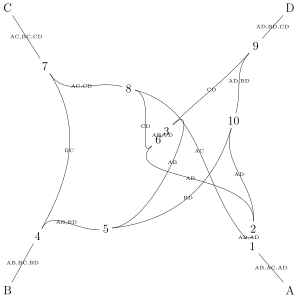

In [33]:
g = graph_list[79]
source_positions = [
[20.0,00.0],
[0.0,0.0],
[0.0,20.0],
[20.0,20.0]
]
tikz_string,stacked = tikz_string_graph(g,source_list,path_list,starting_edges,source_positions,true)
tp = TikzPicture(tikz_string
    , options="scale=0.5", preamble="")

In [38]:
for i=1:length(graph_list)
    g = graph_list[i]
    source_positions = [
    [0.0,0.0],
    [0.0,20.0],
    [20.0,0.0],
    [20.0,20.0]
    ]
    tikz_string,stacked = tikz_string_graph(g,source_list,path_list,starting_edges,source_positions)
    if stacked
        source_positions = [
        [20.0,0.0],
        [0.0,20.0],
        [0.0,0.0],
        [20.0,20.0]
        ]
        tikz_string,stacked = tikz_string_graph(g,source_list,path_list,starting_edges,source_positions)
    end
    if stacked
        source_positions = [
        [0.0,0.0],
        [0.0,20.0],
        [20.0,20.0],
        [20.0,0.0]
        ]
        tikz_string,stacked = tikz_string_graph(g,source_list,path_list,starting_edges,source_positions)
    end
    if stacked
        println(i)
    end
    """tp = TikzPicture(tikz_string
    , options="scale=0.5", preamble="")
    save(SVG("graph_saves/graph_$i.svg"), tp)"""
end